#### Intro

This is a starter notebook showcasing capabilities. 

Fit BOPDMD to SIC data.

* use mask to remove land pixels from training
* window average (window before current time)
* densely sample weekly means around local mins of total ice
* select geographic areas by mask to see local evolution of ice - penguins??

In [1]:
%load_ext autoreload
%autoreload 2

import dill

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pydmd import DMD, BOPDMD, FbDMD, MrDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D
from pydmd.preprocessing import hankel_preprocessing

from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.ndimage import gaussian_filter

from tqdm.autonotebook import tqdm, trange

from scipy.signal import fftconvolve

import torch 

import sys
import os
import pickle
import time

if '../src/modules/' not in sys.path:
    sys.path.append('../src/modules/')

if '../src/modules/' not in sys.path:
    sys.path.append('../src/modules/')

from plot_jupyter import contour_compare, contour_data
from data_wrangle import get_days_before, get_test_set, window_mean, get_days_after
from dmd_routines import reshape_data2dmd, train_dmd, reshape_Psi2data, eval_dmd
from sic_data_functions import get_ice_data, thin_data, iiee_calc, normalise_image, multiple_dfs_to_excel

batched_iiee = torch.func.vmap(iiee_calc)
batched_min = torch.func.vmap(torch.min)
batched_max = torch.func.vmap(torch.max)

C:\Users\MITESH\AppData\Local\Temp\ipykernel_30676\3722543401.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


#### Configs

In [2]:
# to run low res version of SIC images, can choose by how much to reduce the image size by adjusting step_thin, default = 3
run_lowres = False
step_thin = 3

# point in time: training set is before this point and test set is after this point
year = 32 # year within data set
day = 0 # day within year as the starting point 
window = 1 # window-averaging, thesis experiment uses [5,10,20]
num_year_data = 5 # number of years worth of data, thesis experiment with [2,5,7,10] years worth of history
T_train = 365 * num_year_data  # how many days worth of data needed
T_test = 365 * 2

#DMD rank
rank = 5

if run_lowres:
    img_type = 'lowres'
else:
    img_type = "highres"

#### Data Import


In [3]:
DATA, mask, x,y,Y_mean_month, Y_mean_week = get_ice_data(return_all = True)
del Y_mean_month, Y_mean_week

In [4]:
contour_compare(DATA[0], DATA[1])

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=364), IntSlider(value=157, description='f…

Thin spatial mesh: For prototyping

In [5]:
if run_lowres:
    DATA, mask = thin_data(DATA, mask, step_thin)
    x = x[::step_thin]
    y = y[::step_thin]

nx = len(x)
ny = len(y)

DATA[0].shape

(365, 314, 314)

##### Train DMD without UQ

##### Choose interval and train

In [6]:
# compute windowed mean. Returns T_train snapshots before current time point (not inclusive)

X0_ = get_days_before(DATA, year, day, T_train+window-1) # get days from DATA
X1_ = get_days_after(DATA, year, day,T_test)

if window > 1:
    X0_ = window_mean(X0_, window = window, t = None) # compute window mean, 
    X1_ = get_test_set(DATA, year, day, window, T_test)

X0_.shape, X1_.shape

((1825, 314, 314), (730, 314, 314))

prepare data

In [7]:
t_train = np.arange(-T_train, 0)

# time delay and dmd snapshots
X_delayed, t_delayed, data_shape = reshape_data2dmd(X0_, 
                                                    t_train, 
                                                    time_delay = 2, 
                                                    mask = mask,
                                                    isKeepFirstTimes = True)

X_delayed.shape, t_delayed.shape, data_shape

#land mass is removed and then the two images are stacked to introduce non-stationarity 

((152098, 1824), (1824,), (1825, 314, 314))

train dmd

In [8]:
# # train dmd
# Lambda, Psi_, bn = train_dmd(X_delayed, t_delayed, svd_rank = rank, 
#                              eig_constraints={
#                                 "stable", # choose Re(lambda)<0
#                                 "conjugate_pairs", # force complex conjugate pairs
#                                 } 
# )
# # reshape Psi to non-time-lagged spacial domain
# Psi = reshape_Psi2data(Psi_, data_shape, mask = mask) # reshape to non-time-delayed shape

In [9]:
# nonzero = []
# # A = X0_[:,0,0].reshape(X0.shape[0],1)
# for i in range(X_delayed.shape[0]):
#         if np.sum(X_delayed[i, :]) != 0:
#             nonzero.append(X_delayed[i, :])

# X_delayed_nonzero = np.array(nonzero)

In [10]:
# # train dmd
# Lambda, Psi_, bn = train_dmd(X_delayed, t_delayed, svd_rank = rank, 
#                              eig_constraints={
#                                 "stable", # choose Re(lambda)<0
#                                 "conjugate_pairs", # force complex conjugate pairs
#                                 } 
# )
# # reshape Psi to non-time-lagged spacial domain
# Psi = reshape_Psi2data(Psi_, data_shape, mask = mask) # reshape to non-time-delayed shape

# X_pred_test = eval_dmd(Lambda, Psi_.T, bn, range(729))

In [11]:
dmd_avg_stats = []
dmd_MSE =[]
dmd_IIEE = []
dmd_MAE = []
dmd_true_integral =[]
dmd_pred_integral =[]

pred_len = 180

t_all = np.arange(-T_train, T_test)

stats_dir = r'../outputs/stats/'

#svd_ranks = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
svd_ranks = [5]

for i in svd_ranks:
    Lambda, Psi_, bn = train_dmd(X_delayed, t_delayed, svd_rank = i, 
                                eig_constraints={
                                    "stable", # choose Re(lambda)<0
                                    "conjugate_pairs", # force complex conjugate pairs
                                    } 
    )
    # reshape Psi to non-time-lagged spacial domain
    Psi = reshape_Psi2data(Psi_, data_shape, mask = mask) # reshape to non-time-delayed shape

    X_pred_test = eval_dmd(Lambda, Psi, bn, t_all)

    x_pred_testset = X_pred_test[T_train:,:,:]

    with open(stats_dir + 'forecasted_images/bopdmd_SIC_win_{}_history_{}_SVD_{}.pkl'.format(window,num_year_data,i), 'wb') as output:
        pickle.dump(x_pred_testset[:180], output)

    mse_per_img = ((x_pred_testset - X1_)**2).sum(axis=(1,2))/(X1_.shape[2]**2)

    mae_per_img = (np.abs(x_pred_testset - X1_)).sum(axis=(1,2))/(X1_.shape[2]**2)

    iiee_pred = batched_iiee(torch.Tensor(x_pred_testset), torch.Tensor(X1_))

    total_iiee = iiee_calc(torch.Tensor(x_pred_testset[:pred_len]), torch.Tensor(X1_[:pred_len]))#,c_e = 0.0)

    avg_mse = mse_per_img[:pred_len].sum()/pred_len
    avg_iiee = iiee_pred[:pred_len].sum()/pred_len
    avg_mae = mae_per_img[:pred_len].sum()/pred_len


    Integral_pred = np.trapz(np.trapz((X_pred_test[T_train::])[:180], x, axis = 2), y, axis = 1)
    Integral_true = np.trapz(np.trapz(X1_[:180], x, axis = 2), y, axis = 1)
    # avg_mse_top = mse_per_img[:300].sum()/300
    dmd_avg_stats.append([int(i), avg_mse, avg_iiee.numpy().item(0), avg_mae])

    dmd_MSE.append(mse_per_img[:pred_len])
    dmd_MAE.append(mae_per_img[:pred_len])

    dmd_IIEE.append(iiee_pred[:pred_len].numpy())
    dmd_pred_integral.append(Integral_pred[:pred_len])
    dmd_true_integral.append(Integral_true[:pred_len])
    #print("test set mse for bopdmd: {}".format(avg_mse))
    
    print("SVD Rank: {} Test set MSE for BOPDMD 180 fwd: {:3f}  Test set IIEE for BOPDMD 180 fwd: {:3f}, Test set MAE for BOPDMD 180 fwd: {:3f}".format(i,avg_mse, avg_iiee, avg_mae))

    #filename = window, num_year_data, run_lowres, 

#C:\Project\0UCL_MSC_Project\outputs\pkl\pkl_bopdmd
## need to run 2,5,7,10 year history

## along with moving avg of 1,5,10,20
    #del 
    # plt.plot(mse_per_img)
    # plt.show()

c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\pydmd\bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


SVD Rank: 5 Test set MSE for BOPDMD 180 fwd: 0.010847  Test set IIEE for BOPDMD 180 fwd: 3169.344482, Test set MAE for BOPDMD 180 fwd: 0.034314


In [12]:
dmd_avg_stats_np = np.array(dmd_avg_stats)

dmd_avg_stats_df = pd.DataFrame(dmd_avg_stats_np)

dmd_MSE_np = np.array(dmd_MSE)
dmd_MAE_np = np.array(dmd_MAE)
dmd_IIEE_np = np.array(dmd_IIEE)
dmd_pred_integral_np = np.array(dmd_pred_integral)
dmd_true_integral_np = np.array(dmd_true_integral)

print(dmd_MSE_np,dmd_MAE_np ,dmd_IIEE_np)

column_indices = [0,1,2,3]
new_names = ['SVD rank','MSE','IIEE', 'MAE']
old_names = dmd_avg_stats_df.columns[column_indices]
dmd_avg_stats_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

dmd_avg_stats_df = dmd_avg_stats_df.astype({"SVD rank": int})

min_mse = dmd_avg_stats_df[dmd_avg_stats_df["MSE"] == dmd_avg_stats_df["MSE"].min()]
min_mae = dmd_avg_stats_df[dmd_avg_stats_df["MAE"] == dmd_avg_stats_df["MAE"].min()]
min_iiee = dmd_avg_stats_df[dmd_avg_stats_df["IIEE"] == dmd_avg_stats_df["IIEE"].min()]


dmd_pred_integral_df = pd.concat((pd.DataFrame(svd_ranks),pd.DataFrame(dmd_pred_integral_np)), axis = 1, join= 'inner')
dmd_true_integral_df = pd.concat((pd.DataFrame(svd_ranks),pd.DataFrame(dmd_true_integral_np)), axis = 1, join= 'inner')
dmd_MSE_df =  pd.concat((pd.DataFrame(svd_ranks),pd.DataFrame(dmd_MSE_np)), axis = 1, join= 'inner')
dmd_MAE_df =  pd.concat((pd.DataFrame(svd_ranks),pd.DataFrame(dmd_MAE_np)), axis = 1, join= 'inner')
dmd_IIEE_df = pd.concat((pd.DataFrame(svd_ranks),pd.DataFrame(dmd_IIEE_np*(25**2))), axis = 1, join= 'inner')


print(dmd_avg_stats_df)

[[0.01278978 0.01274998 0.01285845 0.01263185 0.01243224 0.01214248
  0.01194732 0.01160101 0.01145158 0.01077363 0.01058441 0.01008598
  0.00966985 0.00906718 0.00860086 0.00846348 0.00845029 0.00802327
  0.00790967 0.00781206 0.00773864 0.00714507 0.0067819  0.00661641
  0.00662583 0.00675245 0.00682625 0.0066683  0.00650033 0.00641108
  0.00657447 0.00672875 0.00654063 0.00621365 0.00599821 0.00597544
  0.00593536 0.00611134 0.00564035 0.00556169 0.00560244 0.00560255
  0.00579026 0.0057609  0.00549151 0.00558232 0.00561234 0.00537951
  0.00560513 0.0058465  0.00542657 0.00522201 0.0052331  0.00519021
  0.00551514 0.00554852 0.00527557 0.0052105  0.00553105 0.00577971
  0.00600327 0.00643186 0.00693624 0.00729293 0.00806426 0.00847122
  0.00881904 0.00864547 0.00771589 0.0082147  0.0094015  0.00985245
  0.00946587 0.00942774 0.00968409 0.01033281 0.01141039 0.01195692
  0.01314104 0.01363159 0.01351361 0.01194175 0.01185363 0.0114449
  0.01154819 0.01156257 0.01115287 0.01132642 0.0

In [13]:
pd_list = [dmd_MSE_df,dmd_MAE_df,dmd_IIEE_df,dmd_pred_integral_df,dmd_true_integral_df,dmd_avg_stats_df]
pd_sheets = ['dmd_MSE_df','dmd_MAE_df','dmd_IIEE_df','dmd_pred_integral_df','dmd_true_integral_df','dmd_avg_stats_df']


# dmd_avg_stat_df.to_csv(stats_dir + "Seq_DMD_avg_stat_df.csv")
# dmd_latent_recon_df.to_csv(stats_dir + "Seq_DMD_latentrecon_stat_df.csv")
# dmd_latent_fwd_df.to_csv(stats_dir + "Seq_DMD_avg_latentfwd_df.csv")

multiple_dfs_to_excel(pd_list,pd_sheets, stats_dir + "bopdmd_all_stats.xlsx")

In [14]:
# with open(r'../outputs/pkl/pkl_bopdmd/bopdmd_sic_window_' + str(window)+'_numyears_'+ str(num_year_data) +'_' + str(img_type) + '_' + time.strftime("%Y%m%d"), 'wb') as output:
#      pickle.dump([dmd_avg_stats_df,dmd_MSE_df, dmd_MAE_df, dmd_IIEE_df], output)

In [15]:
import seaborn as sns
from pypalettes import get_hex

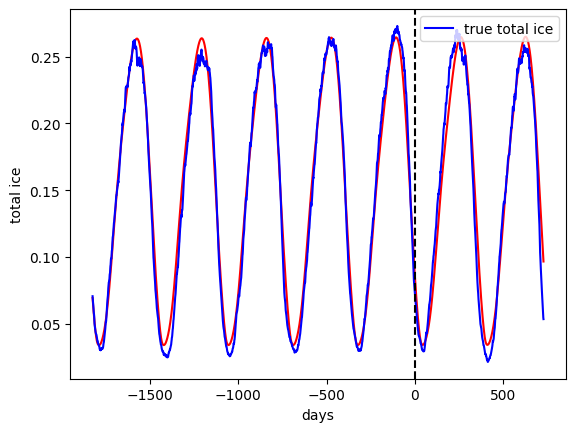

In [16]:
X_true = np.concatenate((X0_, X1_))

Integral_pred = np.trapz(np.trapz(X_pred_test, x, axis = 2), y, axis = 1)
Integral_true = np.trapz(np.trapz(X_true, x, axis = 2), y, axis = 1)

plt.plot(t_all, Integral_pred.T, color = 'red');
plt.plot(t_all, Integral_true, label = 'true total ice', color = 'b')

plt.axvline(0, linestyle = '--', color = 'k')

plt.ylabel('total ice')
plt.xlabel('days')

plt.legend(loc = 'upper right')

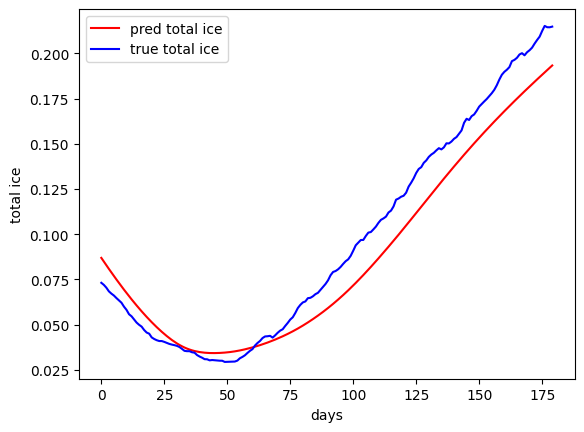

In [17]:

t_test = np.arange(0, 180)

Integral_pred = np.trapz(np.trapz((X_pred_test[T_train::])[:180], x, axis = 2), y, axis = 1)
Integral_true = np.trapz(np.trapz(X1_[:180], x, axis = 2), y, axis = 1)

plt.plot(t_test, Integral_pred.T, color = 'red', label = 'pred total ice')
plt.plot(t_test, Integral_true, label = 'true total ice', color = 'b')

#plt.axvline(0, linestyle = '--', color = 'k')

plt.ylabel('total ice')
plt.xlabel('days')

plt.legend(loc = 'best')

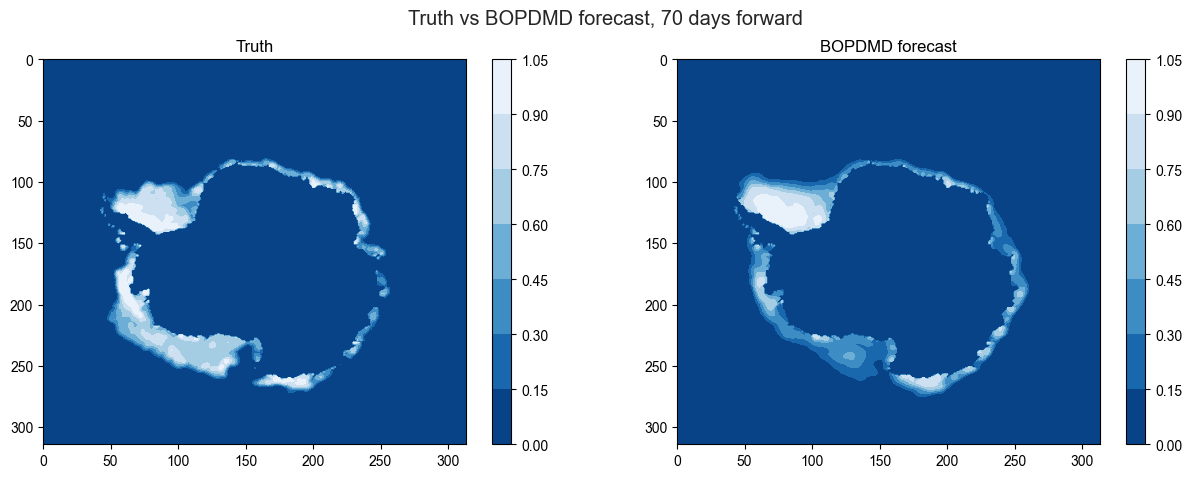

In [18]:
fig_1, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

sns.color_palette("crest", as_cmap=True)
palette = get_hex("Aluterus_scriptus", keep_first_n=5)

ax_1 = ax1.contourf(X1_[70], cmap=plt.get_cmap('Blues_r'))
ax1.set_title("Truth")
ax1.set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_2 = ax2.contourf(x_pred_testset[70], cmap=plt.get_cmap('Blues_r'))
ax2.set_title("BOPDMD forecast")
ax2.set_ylim(314, 0)
cbar2 = fig_1.colorbar(ax_2)

sns.set(style="darkgrid")

fig_1.suptitle("Truth vs BOPDMD forecast, 70 days forward")
plt.show()

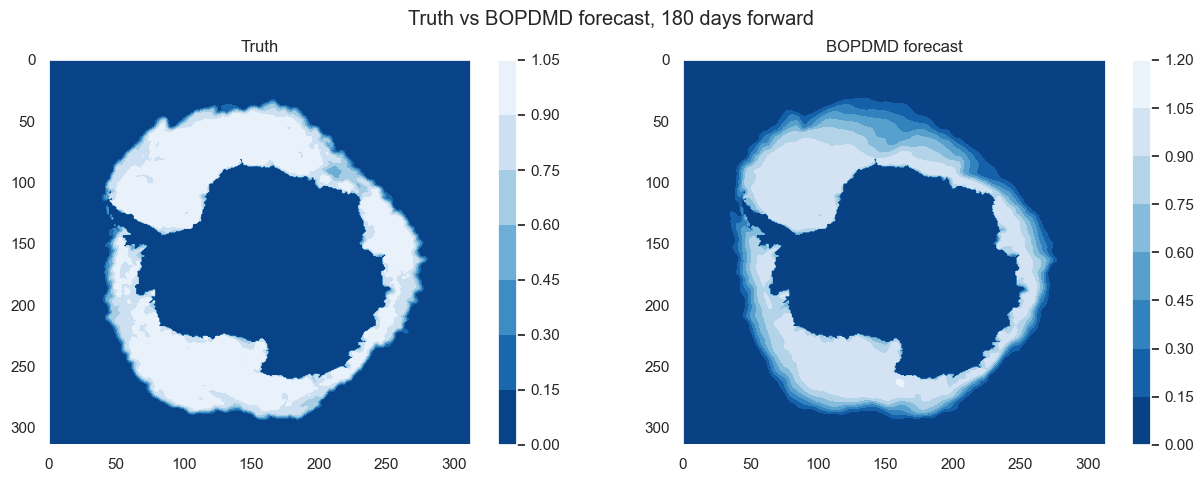

In [19]:
fig_2, (ax3, ax4) = plt.subplots(1,2, figsize=(15,5))

ax_3 = ax3.contourf(X1_[179], cmap=plt.get_cmap('Blues_r'))
ax3.set_title("Truth")
ax3.set_ylim(314, 0)
cbar3 = fig_2.colorbar(ax_3)

ax_4 = ax4.contourf(x_pred_testset[179], cmap=plt.get_cmap('Blues_r'))
ax4.set_title("BOPDMD forecast")
ax4.set_ylim(314, 0)
cbar4 = fig_2.colorbar(ax_4)

sns.set(style="darkgrid")

fig_2.suptitle("Truth vs BOPDMD forecast, 180 days forward")
plt.show()

In [20]:
contour_compare(x_pred_testset, X1_)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=729), IntSlider(value=157, description='f…

['#f77189', '#bb9832', '#50b131', '#36ada4', '#3ba3ec', '#e866f4']


<Axes: title={'center': 'MAE'}, xlabel='SVD rank', ylabel='MAE'>

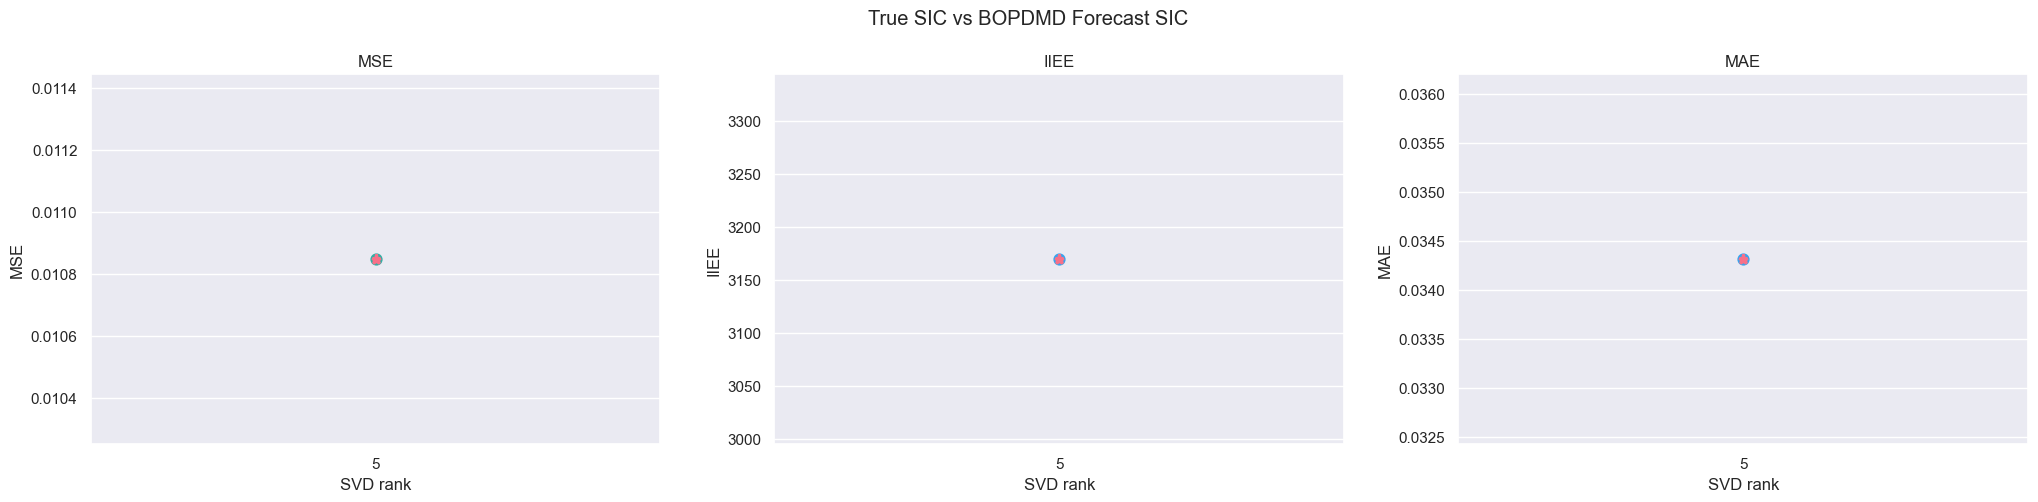

In [21]:
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(25, 5))

pal = sns.color_palette("husl")
print(pal.as_hex())

fig.suptitle("True SIC vs BOPDMD Forecast SIC")
fig.subplots_adjust(top=0.85)
sns.set_palette("husl",8)

sns.pointplot(data = dmd_avg_stats_df,x='SVD rank', y='MSE', ax = axs[0],linestyles='--',color= '#36ada4').set_title("MSE")
sns.pointplot(data = dmd_avg_stats_df,x='SVD rank', y='IIEE', ax = axs[1], linestyles='--', color= '#3ba3ec').set_title("IIEE")
sns.pointplot(data = dmd_avg_stats_df,x='SVD rank', y='MAE', ax = axs[2], linestyles='--', color= '#3ba3ec').set_title("MAE")
#
#axs[0].plot(min_mse["SVD_rank"], min_mse["MSE"], marker="*", color="r", markersize=10)

sns.pointplot(data = min_mse,x='SVD rank', y='MSE', ax = axs[0], markers= '*', color= '#f77189')
sns.pointplot(data = min_iiee,x='SVD rank', y='IIEE', ax = axs[1], markers= '*', color= '#f77189')
sns.pointplot(data = min_iiee,x='SVD rank', y='MAE', ax = axs[2], markers= '*', color= '#f77189')


#plt.show()

explore trained via integration

In [22]:
# t_all = np.arange(-T_train, T_train)
# true_after = get_test_set(DATA, year, day, window, T_train)
# X_true = np.concatenate((X0_, true_after), axis = 0)

# X_pred = eval_dmd(Lambda, Psi, bn, t_all)
# # COMPUTE METRIC OF PREDICTION
# Integral_pred = np.trapz(np.trapz(X_pred, x, axis = 2), y, axis = 1)
# Integral_true = np.trapz(np.trapz(X_true, x, axis = 2), y, axis = 1)

# plt.plot(t_all, Integral_pred.T, color = 'grey');
# plt.plot(t_all, Integral_true, label = 'true total ice', color = 'r')

# plt.axvline(0, linestyle = '--', color = 'k')

# plt.ylabel('total ice')
# plt.xlabel('days')

# plt.legend(loc = 'upper right')
# # plt.xlim([-120, 10])

In [23]:
# mse_perimage_chck = ((dec_test_arr - X1_)**2).sum(axis=(1,2))/(X1_.shape[2]**2)

# mse_avg_chk = mse_perimage_chck.sum()/X1_.shape[0]
# mse_avg_chk

# plt.plot(mse_perimage_chck)
# plt.show()

# iiee_chck = batched_iiee(torch.Tensor(dec_test_arr), torch.Tensor(X1_))

# plt.plot(iiee_chck)
# plt.show()

c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


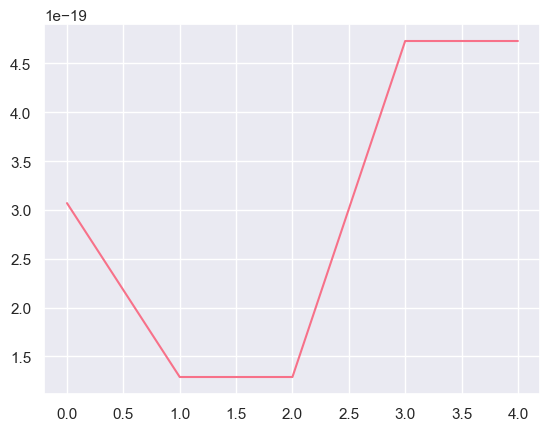

In [24]:
plt.plot(Psi_[1000,:])
plt.show()

In [25]:
contour_data(Psi.imag)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=4), IntSlider(value=157, description='f_i…

In [26]:
contour_data(Psi.real)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=4), IntSlider(value=157, description='f_i…

In [27]:
contour_compare(X_true, X_pred)

NameError: name 'X_pred' is not defined

In [ ]:
#plt.plot(DATA[0][0],)
plt.contourf(DATA[30][350], cmap=plt.get_cmap('Blues_r'))
plt.show()